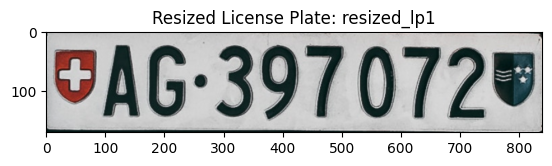

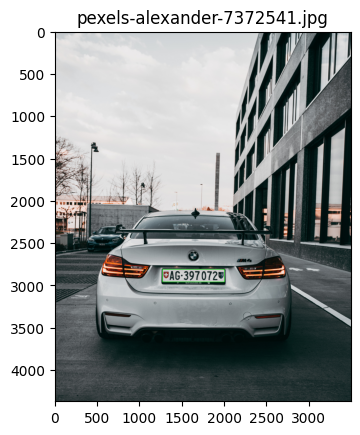

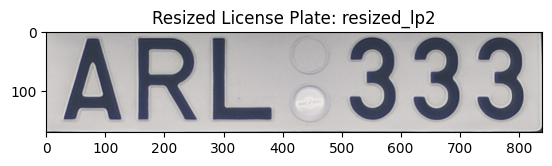

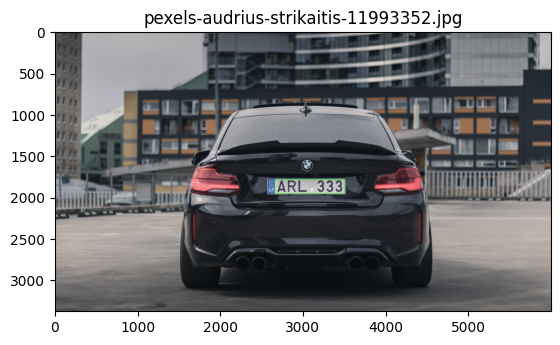

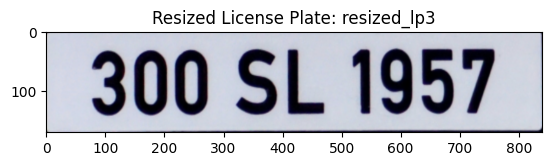

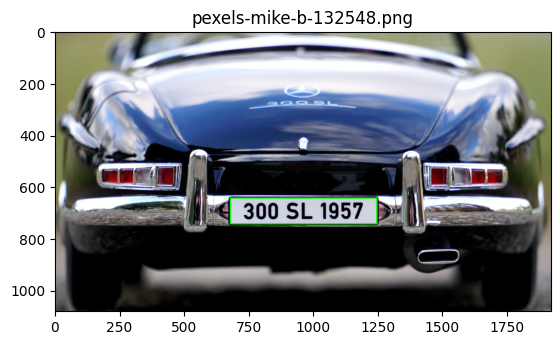

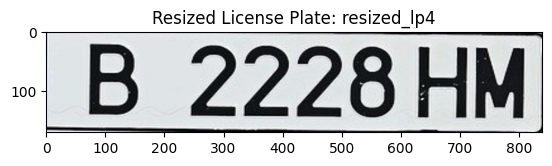

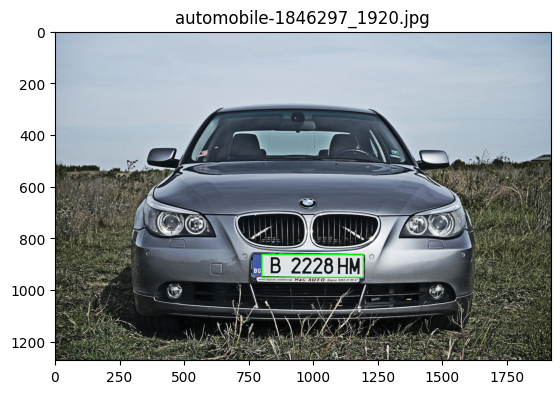

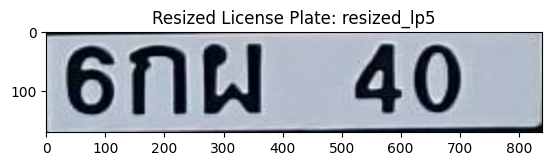

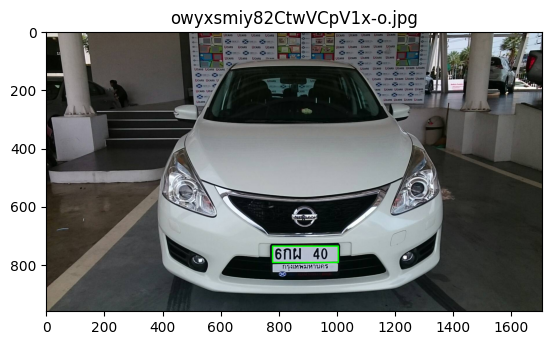

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to find and crop license plate
def find_and_crop_license_plate(image, counter, target_height=170, target_width=840):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # HSV White to Gray
    lower_bound = np.array([0, 0, 200])
    upper_bound = np.array([255, 40, 255])

    # Create a binary mask based on the color range
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    result = image.copy()

    # Iterate through contours and filter based on area, aspect ratio, and size
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if 10000 < area < 80000 and 4.03 < aspect_ratio < 6 and 20 < h < 200:
            cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), thickness=4)

            # Crop the license plate region from the image
            cropped_license_plate = image[y:y + h, x:x + w]

            # Resize the cropped license plate to the specified dimensions
            resized_license_plate = cv2.resize(cropped_license_plate, (target_width, target_height))

            # Save the resized license plate
            save_filename = os.path.join(save_path, f'resized_lp{counter}.jpg')
            cv2.imwrite(save_filename, resized_license_plate)

            # Display the resized license plate
            plt.imshow(cv2.cvtColor(resized_license_plate, cv2.COLOR_BGR2RGB))
            plt.title(f'Resized License Plate: resized_lp{counter}')
            plt.show()

            # Increment counter
            counter += 1

    return result, counter

folder_path = '/content/drive/MyDrive/CV_PRo/data/'

# Counter for naming variables
counter = 1

# Target dimensions for resizing
target_height = 170
target_width = 840

# Directory to save the processed images
save_path = '/content/drive/MyDrive/CV_FINAL/Proceeds'

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):

        img_path = os.path.join(folder_path, filename)
        image = cv2.imread(img_path)

        # Find and crop license plate
        result_image, counter = find_and_crop_license_plate(image, counter, target_height, target_width)

        # Save the result image
        result_filename = os.path.join(save_path, f'result_{filename}')
        cv2.imwrite(result_filename, result_image)

        # Display the result for each image
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(filename)
        plt.show()


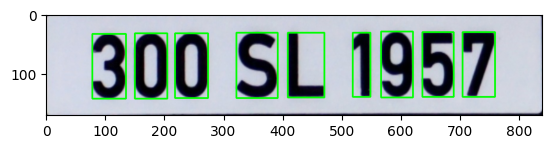

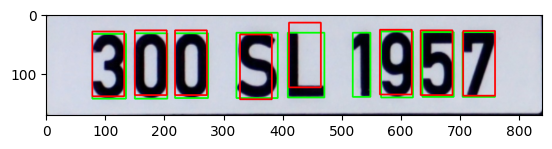

Match License plate:
3005L957


In [42]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

# Function to perform image segmentation and draw rectangles around characters
def segment_and_draw_rectangles(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, bw = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    character_regions = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        ratio = w / h

        if cv2.contourArea(contour) > 700 and ratio < 0.7:
            character_regions.append((x, y, w, h))
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), thickness=2)

    return image, character_regions


url = '/content/drive/MyDrive/CV_FINAL/Proceeds/resized_lp3.jpg'
img = cv2.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Perform image segmentation and draw rectangles
img_with_rectangles, character_regions = segment_and_draw_rectangles(img)


plt.imshow(img_with_rectangles)
plt.show()

# Template matching
template_folder = '/content/drive/MyDrive/CV_PRo/template'
template_files = os.listdir(template_folder)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Create a mask to keep track of detected regions
mask = np.zeros_like(gray)

# List to store matched template filenames and their corresponding x-coordinates
matched_templates = []

# Create a copy of the original image for drawing rectangles
img_with_matches = img.copy()

for template_file in template_files:
    template_path = os.path.join(template_folder, template_file)
    template = cv2.imread(template_path)



    # Resize template to match average width and height of character regions
    avg_width = np.mean([region[2] for region in character_regions])
    avg_height = np.mean([region[3] for region in character_regions])
    resized_template = cv2.resize(template, (int(avg_width), int(avg_height)))

    temp = cv2.cvtColor(resized_template, cv2.COLOR_BGR2GRAY)

    # Template matching
    res = cv2.matchTemplate(gray, temp, cv2.TM_CCOEFF_NORMED)
    threshold = 0.7
    loc = np.where(res >= threshold)

    w_template = resized_template.shape[1]
    h_template = resized_template.shape[0]

    for (x, y) in zip(loc[1], loc[0]):

        # Check if the detected region overlaps with any existing detection

        if np.any(mask[y:y+h_template, x:x+w_template] != 0):
            continue  # Skip this match if it overlaps with existing match

        matched_templates.append((template_file, x))

        # Adjust the size of the bounding box if it's too large
        resized_w = min(w_template, character_regions[0][2])
        resized_h = min(h_template, character_regions[0][3])

        # Adjust the size of the bounding box if it's too small
        resized_w = max(w_template, resized_w)
        resized_h = max(h_template, resized_h)

        cv2.rectangle(img_with_matches, (x, y), (x + resized_w, y + resized_h), (255, 0, 0), 2)


        # Update the mask to mark the detected region
        mask[y:y+resized_h, x:x+resized_w] = 255

# Sort matched template filenames based on x-coordinate of top-left corner
matched_templates.sort(key=lambda x: x[1])



# Display the image with matched template and rectangles
plt.imshow(img_with_matches)
plt.show()

print("Match License plate:")
matched_filename_concatenated = ""
for template_file, _ in matched_templates:
    matched_filename_concatenated += template_file.split('.')[0]
print(matched_filename_concatenated)
